Predicting which station needs more docks on the basis of the traffic ( to and fro) at the station. This is also by keeping in mind the revenue generated v/s the cost required to build more docks

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc, os


Combine bicycle data with station data and merge all years data

In [4]:
#Training Data
trip_2017_q1 = pd.read_csv("C:/DPA Project/data/Divvy_Trips_2017_Q1.csv")
trip_2017_q2 = pd.read_csv("C:/DPA Project/data/Divvy_Trips_2017_Q2.csv")
trip_2017_q3 = pd.read_csv("C:/DPA Project/data/Divvy_Trips_2017_Q3.csv")
trip_2017_q4 = pd.read_csv("C:/DPA Project/data/Divvy_Trips_2017_Q4.csv")

merge_2017 = pd.concat([trip_2017_q1, trip_2017_q2, trip_2017_q3, trip_2017_q4],ignore_index= True)
merge_2017 = merge_2017.reindex(index=[i for i in range(merge_2017.shape[0])])

#trip_2018_q1 = pd.read_csv("C:/DPA Project/data/Divvy_Trips_2018_Q1.csv")
trip_2018_q2 = pd.read_csv("C:/DPA Project/data/Divvy_Trips_2018_Q2.csv")
trip_2018_q3 = pd.read_csv("C:/DPA Project/data/Divvy_Trips_2018_Q3.csv")
trip_2018_q4 = pd.read_csv("C:/DPA Project/data/Divvy_Trips_2018_Q4.csv")

merge_2018 = pd.concat([trip_2018_q2, trip_2018_q3, trip_2018_q4],ignore_index= True)
merge_2018 = merge_2018.reindex(index=[i for i in range(merge_2018.shape[0])])


#Total Data pf 2017 & 2018
merge_total = pd.concat([merge_2017, merge_2018],ignore_index= True)
merge_total = merge_total.reindex(index=[i for i in range(merge_total.shape[0])])
merge_total_orig = merge_total.reindex(index=[i for i in range(merge_total.shape[0])])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [140]:
#Test Data
trip_2019_q1 = pd.read_csv("C:/DPA Project/data/Divvy_Trips_2019_Q1.csv")
#trip_2019_q2 = pd.read_csv("C:/DPA Project/data/Divvy_Trips_2019_Q2.csv")
trip_2019_q3 = pd.read_csv("C:/DPA Project/data/Divvy_Trips_2019_Q3.csv")
trip_2019_q4 = pd.read_csv("C:/DPA Project/data/Divvy_Trips_2019_Q4.csv")

merge_2019 = pd.concat([trip_2019_q1, trip_2019_q3, trip_2019_q4],ignore_index= True)
merge_2019 = merge_2019.reindex(index=[i for i in range(merge_2019.shape[0])])
merge_2019_orig = merge_2019.reindex(index=[i for i in range(merge_2019.shape[0])])

In [5]:
station_data = pd.read_csv("C:/DPA Project/data/Divvy_Bicycle_Stations.csv")

In [6]:
#Merging Total Docks, To Latitude & To Longitude Data in Training Dataframe
merge_total['total_docks'] =  merge_total['from_station_id'].map(station_data.set_index('ID')['Total Docks'])
merge_total['to_latitude'] = merge_total['to_station_id'].map(station_data.set_index('ID')['Latitude'])
merge_total['to_longitude'] = merge_total['to_station_id'].map(station_data.set_index('ID')['Longitude'])
merge_total['from_latitude'] = merge_total['from_station_id'].map(station_data.set_index('ID')['Latitude'])
merge_total['from_longitude'] = merge_total['from_station_id'].map(station_data.set_index('ID')['Longitude'])



In [141]:
#Merging Total Docks, To Latitude & To Longitude Data in Test Dataframe
merge_2019['total_docks'] =  merge_2019['from_station_id'].map(station_data.set_index('ID')['Total Docks'])
merge_2019['to_latitude'] = merge_2019['to_station_id'].map(station_data.set_index('ID')['Latitude'])
merge_2019['to_longitude'] = merge_2019['to_station_id'].map(station_data.set_index('ID')['Longitude'])
merge_2019['from_latitude'] = merge_2019['from_station_id'].map(station_data.set_index('ID')['Latitude'])
merge_2019['from_longitude'] = merge_2019['from_station_id'].map(station_data.set_index('ID')['Longitude'])

In [7]:
##Calculating Distnace between origin and destination using lat long

from pyproj import Geod

wgs84_geod = Geod(ellps='WGS84') #Distance will be measured on this ellipsoid - more accurate than a spherical method

#Get distance between pairs of lat-lon points
def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) #Yes, this order is correct
  return dist
merge_total['dist_mts'] = Distance(merge_total['to_latitude'].tolist(),merge_total['to_longitude'].tolist(),merge_total['from_latitude'].tolist(),merge_total['from_longitude'].tolist())

In [142]:
merge_2019['dist_mts'] = Distance(merge_2019['to_latitude'].tolist(),merge_2019['to_longitude'].tolist(),merge_2019['from_latitude'].tolist(),merge_2019['from_longitude'].tolist())

In [143]:
merge_2019.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,total_docks,to_latitude,to_longitude,from_latitude,from_longitude,dist_mts
0,21742443,2019-01-01 00:04:37,2019-01-01 00:11:07,2167,390.0,199,Wabash Ave & Grand Ave,84,Milwaukee Ave & Grand Ave,Subscriber,Male,1989.0,31.0,41.891578,-87.648384,41.891466,-87.626761,1794.564576
1,21742444,2019-01-01 00:08:13,2019-01-01 00:15:34,4386,441.0,44,State St & Randolph St,624,Dearborn St & Van Buren St (*),Subscriber,Female,1990.0,27.0,41.876268,-87.629155,41.884730,-87.627734,947.281340
2,21742445,2019-01-01 00:13:23,2019-01-01 00:27:12,1524,829.0,15,Racine Ave & 18th St,644,Western Ave & Fillmore St (*),Subscriber,Female,1994.0,15.0,41.868563,-87.686234,41.858166,-87.656495,2725.863243
3,21742446,2019-01-01 00:13:45,2019-01-01 00:43:28,252,"1,783.0",123,California Ave & Milwaukee Ave,176,Clark St & Elm St,Subscriber,Male,1993.0,15.0,41.902973,-87.631280,41.922695,-87.697153,5887.742780
4,21742447,2019-01-01 00:14:52,2019-01-01 00:20:56,1170,364.0,173,Mies van der Rohe Way & Chicago Ave,35,Streeter Dr & Grand Ave,Subscriber,Male,1994.0,15.0,41.892278,-87.612043,41.896910,-87.621743,955.342948


In [144]:
merge_2019.shape

(2709841, 18)

In [145]:
merge_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2709841 entries, 0 to 2709840
Data columns (total 18 columns):
trip_id              int64
start_time           object
end_time             object
bikeid               int64
tripduration         object
from_station_id      int64
from_station_name    object
to_station_id        int64
to_station_name      object
usertype             object
gender               object
birthyear            float64
total_docks          float64
to_latitude          float64
to_longitude         float64
from_latitude        float64
from_longitude       float64
dist_mts             float64
dtypes: float64(7), int64(4), object(7)
memory usage: 392.8+ MB


Data Cleaning Task

Exclude trip duration that is less than 2 minutes
Exclude trip with missing latitude_start, longitude_start, dpcapacity_start, latitude_end, longitude_end, dpcapacity_end
Exclude trip without gender information
Extract year, month, and day information

In [12]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(4)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [146]:
missing_values_table(merge_total)

Your selected dataframe has 18 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
gender,373652,13.7887
birthyear,357798,13.2037
dist_mts,214,0.0079
to_latitude,194,0.0072
to_longitude,194,0.0072
total_docks,28,0.0010
from_latitude,28,0.0010
from_longitude,28,0.0010


In [147]:
missing_values_table(merge_2019)

Your selected dataframe has 18 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
gender,373652,13.7887
birthyear,357798,13.2037
dist_mts,214,0.0079
to_latitude,194,0.0072
to_longitude,194,0.0072
total_docks,28,0.0010
from_latitude,28,0.0010
from_longitude,28,0.0010


In [148]:
#Removing records with null values in distance column training dataset
null_index_list=merge_total[merge_total['dist_mts'].isnull()].index.tolist()
merge_total=merge_total.drop(index=null_index_list)

In [151]:
#Removing records with null values in distance column testing dataset
null_index_list=merge_2019[merge_2019['dist_mts'].isnull()].index.tolist()
merge_2019=merge_2019.drop(index=null_index_list)

In [16]:
#Correcting the data type of tripduration field training dataset
merge_total['tripduration'] = merge_total['tripduration'].str.replace(',', '')
merge_total['tripduration'] = merge_total['tripduration'].astype(float)

In [152]:
#Correcting the data type of tripduration field testing dataset
merge_2019['tripduration'] = merge_2019['tripduration'].str.replace(',', '')
merge_2019['tripduration'] = merge_2019['tripduration'].astype(float)

In [17]:
##Adding revenue column basis tripduration charging $3/ 30 minutes ride
merge_total['revenue'] = (merge_total['tripduration']/1800) * 3

In [172]:
##Adding revenue column basis tripduration charging $3/ 30 minutes ride
merge_2019['revenue'] = (merge_2019['tripduration']/1800) * 3


In [18]:
merge_total['tripduration'].describe()

count    3.214965e+06
mean     1.380461e+03
std      2.764318e+04
min      6.100000e+01
25%      4.070000e+02
50%      6.990000e+02
75%      1.260000e+03
max      1.163500e+07
Name: tripduration, dtype: float64

In [19]:
#Removing trips which are less than 2 minutes & greater than 5 hours training data set
merge_total = merge_total[(merge_total['tripduration'] >= 120) & (merge_total['tripduration'] <= 18000)]

In [153]:
#Removing trips which are less than 2 minutes & greater than 5 hours testing data set
merge_2019 = merge_2019[(merge_2019['tripduration'] >= 120) & (merge_2019['tripduration'] <= 18000)]

In [154]:
merge_2019.shape

(2683581, 18)

In [20]:
merge_total['dist_mts'].describe()

count    3.186703e+06
mean     2.145571e+03
std      1.820019e+03
min      0.000000e+00
25%      9.541961e+02
50%      1.591951e+03
75%      2.781165e+03
max      3.677409e+04
Name: dist_mts, dtype: float64

In [21]:
merge_total['dist_mts'].value_counts()

0.000000        117473
1316.447783       9921
1368.170409       7254
4085.493819       6481
1599.734309       6425
                 ...  
8921.565497          1
7953.193298          1
14859.088383         1
4667.338835          1
10946.523592         1
Name: dist_mts, Length: 65292, dtype: int64

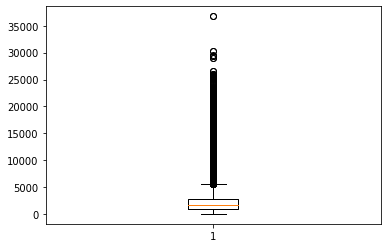

In [22]:
plt.boxplot(merge_total['dist_mts'])
plt.show()

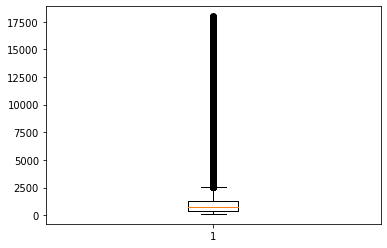

In [23]:
plt.boxplot(merge_total['tripduration'])
plt.show()

In [24]:
#Selecting all those rows where distance travrsed is more than 3 kms & less than 10kms
merge_total.loc[(merge_total['dist_mts'] > 10000)]

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,total_docks,to_latitude,to_longitude,from_latitude,from_longitude,dist_mts,revenue
3829360,18001094,2018-04-01 10:06:16,2018-04-01 11:27:50,2647,4894.0,99,Lake Shore Dr & Ohio St,459,Lakefront Trail & Bryn Mawr Ave,Customer,NaN,NaN,19.0,41.984037,-87.652310,41.892570,-87.614492,10632.487864,8.156667
3829362,18001099,2018-04-01 10:06:37,2018-04-01 11:15:51,2037,4154.0,99,Lake Shore Dr & Ohio St,459,Lakefront Trail & Bryn Mawr Ave,Customer,NaN,NaN,19.0,41.984037,-87.652310,41.892570,-87.614492,10632.487864,6.923333
3829557,18001395,2018-04-01 11:05:14,2018-04-01 12:34:24,377,5350.0,176,Clark St & Elm St,597,Chicago Ave & Washington St,Customer,NaN,NaN,39.0,42.032562,-87.679101,41.902973,-87.631280,14929.656305,8.916667
3829559,18001400,2018-04-01 11:05:41,2018-04-01 12:34:24,3497,5323.0,176,Clark St & Elm St,597,Chicago Ave & Washington St,Customer,NaN,NaN,39.0,42.032562,-87.679101,41.902973,-87.631280,14929.656305,8.871667
3829618,18001485,2018-04-01 11:28:45,2018-04-01 12:23:19,2331,3274.0,459,Lakefront Trail & Bryn Mawr Ave,35,Streeter Dr & Grand Ave,Customer,NaN,NaN,19.0,41.892278,-87.612043,41.984037,-87.652310,10724.975426,5.456667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7043076,21740058,2018-12-30 15:00:34,2018-12-30 16:33:47,1477,5593.0,247,Shore Dr & 55th St,85,Michigan Ave & Oak St,Customer,Female,1984.0,19.0,41.900960,-87.623777,41.795212,-87.580715,12277.862612,9.321667
7043158,21740158,2018-12-30 15:28:07,2018-12-30 16:12:00,764,2633.0,246,Ashland Ave & Belle Plaine Ave,596,Benson Ave & Church St,Subscriber,Male,1981.0,11.0,42.048214,-87.683485,41.956057,-87.668835,10307.889895,4.388333
7043941,21741093,2018-12-31 07:33:45,2018-12-31 08:07:18,1562,2013.0,472,Lincoln Ave & Winona St,66,Clinton St & Lake St,Subscriber,Male,1971.0,15.0,41.885637,-87.641823,41.974911,-87.692503,10770.013009,3.355000
7044343,21741691,2018-12-31 14:25:45,2018-12-31 15:19:35,3304,3230.0,294,Broadway & Berwyn Ave,49,Dearborn St & Monroe St,Subscriber,Male,1946.0,15.0,41.881320,-87.629521,41.978353,-87.659753,11065.512124,5.383333


In [155]:
seriesObj = merge_total.apply(lambda x: True if x['dist_mts'] > 10000 else False , axis=1)
# Count number of True in series
numOfRows = len(seriesObj[seriesObj == True].index)/3192004
print('Number of Rows in dataframe with distance travelled more than 10000 : ', numOfRows)


Number of Rows in dataframe with distance travelled more than 10000 :  0.005158778512740998


In [34]:
##As percentage of people having trips more than 10kms is less than 0.5% therefore dropping those instances from dataframe
merge_total = merge_total.drop(merge_total[merge_total.dist_mts > 10000].index)


In [156]:
seriesObj = merge_2019.apply(lambda x: True if x['dist_mts'] > 5000 else False , axis=1)
# Count number of True in series
numOfRows = len(seriesObj[seriesObj == True].index)/2683581
print('Number of Rows in dataframe with distance travelled more than 5000 : ', numOfRows)


Number of Rows in dataframe with distance travelled more than 5000 :  0.07805801278217427


In [158]:
##As percentage of people having trips more than 5kms is less than 7% therefore dropping those instances from dataframe
merge_2019 = merge_2019.drop(merge_2019[merge_2019.dist_mts > 5000].index)

In [157]:
seriesObj = merge_total.apply(lambda x: True if x['dist_mts'] > 3000 else False , axis=1)
# Count number of True in series
numOfRows = len(seriesObj[seriesObj == True].index)/3192004
print('Number of Rows in dataframe with distance travelled more than 3000 : ', numOfRows)


Number of Rows in dataframe with distance travelled more than 3000 :  0.21865857598485008


In [40]:
##As percentage of people having trips more than 3kms is less than 14% therefore dropping those instances from dataframe
merge_total = merge_total.drop(merge_total[merge_total.dist_mts > 3000].index)

In [43]:
seriesObj = merge_total.apply(lambda x: True if x['dist_mts'] > 2000 else False , axis=1)
# Count number of True in series
numOfRows = len(seriesObj[seriesObj == True].index)/3192004
print('Number of Rows in dataframe with distance travelled more than 2000 : ', numOfRows)


Number of Rows in dataframe with distance travelled more than 2000 :  0.16592930334673767


In [44]:
##As percentage of people having trips more than 2kms is less than 16% therefore dropping those instances from dataframe
merge_total = merge_total.drop(merge_total[merge_total.dist_mts > 2000].index)

In [173]:
merge_2019.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,total_docks,to_latitude,to_longitude,from_latitude,from_longitude,dist_mts,revenue
0,21742443,2019-01-01 00:04:37,2019-01-01 00:11:07,2167,390.0,199,Wabash Ave & Grand Ave,84,Milwaukee Ave & Grand Ave,Subscriber,Male,1989.0,31.0,41.891578,-87.648384,41.891466,-87.626761,1794.564576,0.650000
1,21742444,2019-01-01 00:08:13,2019-01-01 00:15:34,4386,441.0,44,State St & Randolph St,624,Dearborn St & Van Buren St (*),Subscriber,Female,1990.0,27.0,41.876268,-87.629155,41.884730,-87.627734,947.281340,0.735000
2,21742445,2019-01-01 00:13:23,2019-01-01 00:27:12,1524,829.0,15,Racine Ave & 18th St,644,Western Ave & Fillmore St (*),Subscriber,Female,1994.0,15.0,41.868563,-87.686234,41.858166,-87.656495,2725.863243,1.381667
4,21742447,2019-01-01 00:14:52,2019-01-01 00:20:56,1170,364.0,173,Mies van der Rohe Way & Chicago Ave,35,Streeter Dr & Grand Ave,Subscriber,Male,1994.0,15.0,41.892278,-87.612043,41.896910,-87.621743,955.342948,0.606667
5,21742448,2019-01-01 00:15:33,2019-01-01 00:19:09,2437,216.0,98,LaSalle St & Washington St,49,Dearborn St & Monroe St,Subscriber,Female,1983.0,15.0,41.881320,-87.629521,41.882664,-87.632530,290.986090,0.360000


In [160]:
seriesObj = merge_total.apply(lambda x: True if x['tripduration'] > 18000 else False , axis=1)
# Count number of True in series
numOfRows = len(seriesObj[seriesObj == True].index)/3192004
print('Number of Rows in dataframe with distance tripduration is more than 5hrs : ', numOfRows)


Number of Rows in dataframe with distance tripduration is more than 5hrs :  0.0


In [46]:
seriesObj = merge_total.apply(lambda x: True if x['tripduration'] > 10800 else False , axis=1)
# Count number of True in series
numOfRows = len(seriesObj[seriesObj == True].index)/3192004
print('Number of Rows in dataframe with distance tripduration is more than 3hrs : ', numOfRows)


Number of Rows in dataframe with distance tripduration is more than 3hrs :  0.0012346475756296045


In [48]:
##As percentage of people having trips more than 3hrs is less than 0.1% therefore dropping those instances from dataframe
merge_total = merge_total.drop(merge_total[merge_total.tripduration > 10800].index)

In [161]:
seriesObj = merge_2019.apply(lambda x: True if x['tripduration'] > 7200  else False , axis=1)
# Count number of True in series
numOfRows = len(seriesObj[seriesObj == True].index)/2474106
print('Number of Rows in dataframe with distance tripduration is more than 2hrs : ', numOfRows)


Number of Rows in dataframe with distance tripduration is more than 2hrs :  0.008215896974503114


In [49]:
##As percentage of people having trips more than 2hrs is less than 0.6% therefore dropping those instances from dataframe
merge_total = merge_total.drop(merge_total[merge_total.tripduration > 7200].index)

In [62]:
merge_total.shape

(1881375, 19)

In [56]:
seriesObj = merge_total.apply(lambda x: True if x['tripduration'] > 3600  else False , axis=1)
# Count number of True in series
numOfRows = len(seriesObj[seriesObj == True].index)/1935878
print('Number of Rows in dataframe with distance tripduration is more than 1 hrs : ', numOfRows)


Number of Rows in dataframe with distance tripduration is more than 1 hrs :  0.02815415020987893


In [60]:
##As percentage of people having trips more than 1hrs is less than 2% therefore dropping those instances from dataframe
merge_total = merge_total.drop(merge_total[merge_total.tripduration > 3600].index)

In [162]:
seriesObj = merge_2019.apply(lambda x: True if x['tripduration'] > 1800 else False , axis=1)
# Count number of True in series
numOfRows = len(seriesObj[seriesObj == True].index)/2474106
print('Number of Rows in dataframe with distance tripduration is more than 1/2 hrs : ', numOfRows)


Number of Rows in dataframe with distance tripduration is more than 1/2 hrs :  0.0934511294180605


In [163]:
##As percentage of people having trips more than 1hrs is less than 2% therefore dropping those instances from dataframe
merge_2019 = merge_2019.drop(merge_2019[merge_2019.tripduration > 1800].index)

In [58]:
seriesObj = merge_2019.apply(lambda x: True if x['tripduration'] > 900 else False , axis=1)
# Count number of True in series
numOfRows = len(seriesObj[seriesObj == True].index)/2474106
print('Number of Rows in dataframe with distance tripduration is more than 1/2 hrs : ', numOfRows)


Number of Rows in dataframe with distance tripduration is more than 1/2 hrs :  0.1643383519002747


In [59]:
seriesObj = merge_total.apply(lambda x: True if x['tripduration'] > 450 else False , axis=1)
# Count number of True in series
numOfRows = len(seriesObj[seriesObj == True].index)/1935878
print('Number of Rows in dataframe with distance tripduration is more than 1/2 hrs : ', numOfRows)


Number of Rows in dataframe with distance tripduration is more than 1/2 hrs :  0.5254757789488801


In [61]:
merge_total.sort_values(by ='revenue').tail()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,total_docks,to_latitude,to_longitude,from_latitude,from_longitude,dist_mts,revenue
4105773,18329229,2018-05-06 18:33:16,2018-05-06 19:33:16,6343,3600.0,26,McClurg Ct & Illinois St,284,Michigan Ave & Jackson Blvd,Customer,NaN,NaN,31.0,41.877850,-87.624080,41.890359,-87.617532,1491.904571,6.0
5862487,20362847,2018-08-25 13:22:16,2018-08-25 14:22:16,220,3600.0,76,Lake Shore Dr & Monroe St,76,Lake Shore Dr & Monroe St,Customer,NaN,NaN,39.0,41.880958,-87.616743,41.880958,-87.616743,0.000000,6.0
4458541,18741387,2018-06-02 21:32:20,2018-06-02 22:32:20,946,3600.0,6,Dusable Harbor,76,Lake Shore Dr & Monroe St,Customer,NaN,NaN,39.0,41.880958,-87.616743,41.886976,-87.612813,743.771034,6.0
5879712,20382069,2018-08-26 14:38:22,2018-08-26 15:38:22,2394,3600.0,177,Theater on the Lake,177,Theater on the Lake,Customer,NaN,NaN,31.0,41.926277,-87.630834,41.926277,-87.630834,0.000000,6.0
5227585,19634726,2018-07-20 17:05:04,2018-07-20 18:05:04,3119,3600.0,90,Millennium Park,145,Mies van der Rohe Way & Chestnut St,Customer,NaN,NaN,47.0,41.898587,-87.621915,41.881032,-87.624084,1958.141120,6.0


Text(0.5, 0, 'Trip Duration in Minutes')

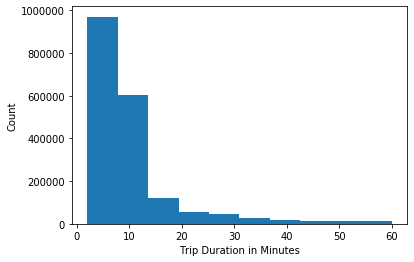

In [132]:
tripd = merge_total['tripduration']/60
plt.hist(tripd)
plt.ylabel('Count')
plt.xlabel('Trip Duration in Minutes')

Text(0.5, 0, 'Trip Duration in Minutes')

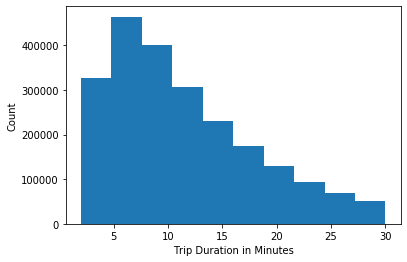

In [164]:
tripd = merge_2019['tripduration']/60
plt.hist(tripd)
plt.ylabel('Count')
plt.xlabel('Trip Duration in Minutes')

Text(0.5, 0, 'Revenue')

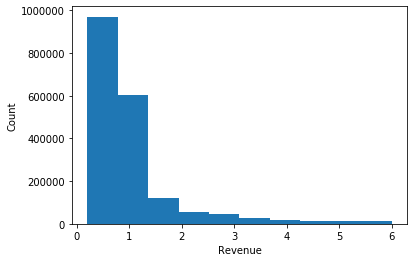

In [133]:
revenue = merge_total['revenue']
plt.hist(revenue)
plt.ylabel('Count')
plt.xlabel('Revenue')

Text(0.5, 0, 'Revenue')

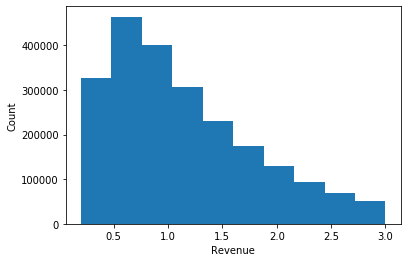

In [174]:
revenue = merge_2019['revenue']
plt.hist(revenue)
plt.ylabel('Count')
plt.xlabel('Revenue')

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV


    Aggregate flows for spatial sankey map

In [67]:
merge_total['trips'] = 1

In [186]:
merge_2019['trips'] = 1

In [68]:
flows = merge_total.groupby(['from_station_id', 'to_station_id'])['trips'].sum().reset_index()

In [69]:
flows.shape

(21176, 3)

In [70]:
# target,source,flow
flows['target'] = flows.to_station_id.map(lambda s: 's' + str(s))
flows['source'] = flows.from_station_id.map(lambda s: 's' + str(s))
flows['flow'] = flows.trips
flows.head()

,from_station_id,to_station_id,trips,target,source,flow
0,2,2,1044,s2,s2,1044
1,2,3,342,s3,s2,342
2,2,5,25,s5,s2,25
3,2,6,128,s6,s2,128
4,2,7,24,s7,s2,24


In [71]:
flows_concise = flows.query('trips >= 1000')[['target', 'source', 'flow']]
print(flows_concise.shape)
flows_concise.head()

(101, 3)


,target,source,flow
0,s2,s2,1044
72,s3,s3,1225
87,s76,s3,1426
89,s90,s3,1668
214,s6,s6,1066


In [89]:
#converting start_time variable to datatime datatype
merge_total['start_time']= pd.to_datetime(merge_total['start_time'])
merge_total['end_time']= pd.to_datetime(merge_total['end_time'])

In [180]:
#converting start_time variable to datatime datatype
merge_2019['start_time']= pd.to_datetime(merge_2019['start_time'])
merge_2019['end_time']= pd.to_datetime(merge_2019['end_time'])

In [85]:
LAST_TRIP = merge_total['start_time'].max()
LAST_TRIP

Timestamp('2018-12-31 23:55:04')

In [182]:
LAST_TRIP = merge_2019['start_time'].max()
LAST_TRIP

Timestamp('2019-12-31 23:57:17')

In [88]:
merge_total['online_duration'] = LAST_TRIP - merge_total['start_time']
merge_total['online_duration_days'] = merge_total.online_duration.astype(('timedelta64[D]'))

In [183]:
merge_2019['online_duration'] = LAST_TRIP - merge_2019['start_time']
merge_2019['online_duration_days'] = merge_2019.online_duration.astype(('timedelta64[D]'))

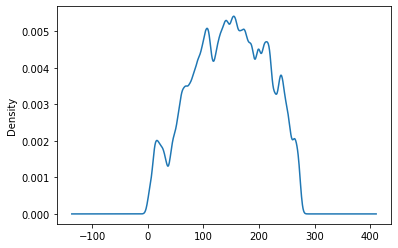

In [90]:
merge_total.online_duration_days.plot.kde()

In [112]:
#Adding month year column
merge_total['month_year'] = merge_total.start_time.map(lambda x: x.strftime('%Y-%m'))

merge_total['year'] = merge_total.start_time.map(lambda x: x.strftime('%Y'))

In [184]:
#Adding month year column
merge_2019['month_year'] = merge_2019.start_time.map(lambda x: x.strftime('%Y-%m'))

merge_2019['year'] = merge_2019.start_time.map(lambda x: x.strftime('%Y'))

In [96]:
merge_total.groupby('month_year')['month_year'].agg('count')

month_year
2018-04    129196
2018-05    226156
2018-06    252798
2018-07    293573
2018-08    298375
2018-09    254252
2018-10    219613
2018-11    117369
2018-12     90043
Name: month_year, dtype: int64

In [109]:
trip_counts = merge_total.groupby(['from_station_id'])['trips'].agg('sum').reset_index()
trip_counts = trip_counts.rename(columns={'from_station_id':'id'})

In [187]:
trip_counts = merge_2019.groupby(['from_station_id'])['trips'].agg('sum').reset_index()
trip_counts = trip_counts.rename(columns={'from_station_id':'id'})

In [192]:
df_train = pd.merge(merge_total, trip_counts)
df_train['trips_per_day'] = df_train.trips / df_train.online_duration_days
df_train.shape

(1881375, 26)

In [193]:
df_test = pd.merge(merge_2019, trip_counts)
df_test['trips_per_day'] = df_test.trips / df_test.online_duration_days
df_test.shape

(2242898, 26)

In [189]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2242898 entries, 0 to 2242897
Data columns (total 26 columns):
trip_id                 int64
start_time              datetime64[ns]
end_time                datetime64[ns]
bikeid                  int64
tripduration            float64
from_station_id         int64
from_station_name       object
to_station_id           int64
to_station_name         object
usertype                object
gender                  object
birthyear               float64
total_docks             float64
to_latitude             float64
to_longitude            float64
from_latitude           float64
from_longitude          float64
dist_mts                float64
revenue                 float64
online_duration         timedelta64[ns]
online_duration_days    float64
month_year              object
year                    object
trips                   int64
id                      int64
trips_per_day           float64
dtypes: datetime64[ns](2), float64(11), int64(6), o

Build Model

In [194]:
INDICATOR = 'trips_per_day'
features = ['to_latitude', 'to_longitude', 'from_latitude', 'from_longitude']
X_train = df_train[features]
y_train = df_train[INDICATOR]
X_test = df_test[features]
y_test = df_test[INDICATOR]

In [197]:
model = KNeighborsRegressor(n_neighbors=8, weights='distance')
model.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').